In [10]:
import pandas as pd
df = pd.read_csv("http://pvexpect.com/Driftsledelse/Dagligvarer/plan.csv")
df["Niveau"]=df["Niveau"].astype("float")
df

,Niveau_1,Niveau_2,Niveau_3,Start_dato,Slut_dato,Resourcer,Fremskridt,Niveau,Beskrivelse
0,1. Forretningsforståelse,1. Forretningsforståelse,1. Forretningsforståelse,2021.02.02,2021.02.22,NaN,80,1.0,Lag en raskere optimalisert verdikjede med lok...
1,1. Forretningsforståelse,1.1 Afgør forretningsmål,1.1 Afgør forretningsmål,2021.02.02,2021.02.22,NaN,80,2.0,Lag en raskere optimalisert verdikjede med lok...
2,1. Forretningsforståelse,1.1 Afgør forretningsmål,1.1.1 Organisation,2021.02.02,2021.02.22,NaN,80,3.0,"En norsk daglig kjede, som fordeler seg nasjon..."
3,1. Forretningsforståelse,1.1 Afgør forretningsmål,1.1.1.1 Udvikle organisationskort,2021.02.02,2021.02.22,NaN,80,4.0,"Økonomi, HR, utvikling, kunder, administrasjon..."
4,1. Forretningsforståelse,1.1 Afgør forretningsmål,1.1.1.2 Identificer nøglepersoner,2021.02.02,2021.02.22,NaN,80,4.0,"Digital driftsleder, ansvarlig for prosjektled..."
...,...,...,...,...,...,...,...,...,...
87,2. Data forståelse,2.4 Kontroller datakvaliteten,2.4.5 Fastslå betydningen af manglende data,2021.03.02,2021.03.26,NaN,0,3.0,NaN
88,2. Data forståelse,2.4 Kontroller datakvaliteten,2.4.6 Kontroller for attributter med forskelli...,2021.03.02,2021.03.26,NaN,0,3.0,NaN
89,2. Data forståelse,2.4 Kontroller datakvaliteten,2.4.7 Kontroller stavning og format for værdie...,2021.03.02,2021.03.26,NaN,0,3.0,NaN
90,2. Data forståelse,2.4 Kontroller datakvaliteten,"2.4.8 Kontroller for afvigelser, og beslut, om...",2021.03.02,2021.03.26,NaN,0,3.0,NaN


Filen kan lagres som excel fil. 

In [13]:
df.to_excel('plan.xlsx')

Filen kan findes under "Files" i venstre side.

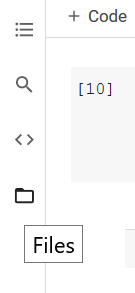

Tryk på download for at hente filen

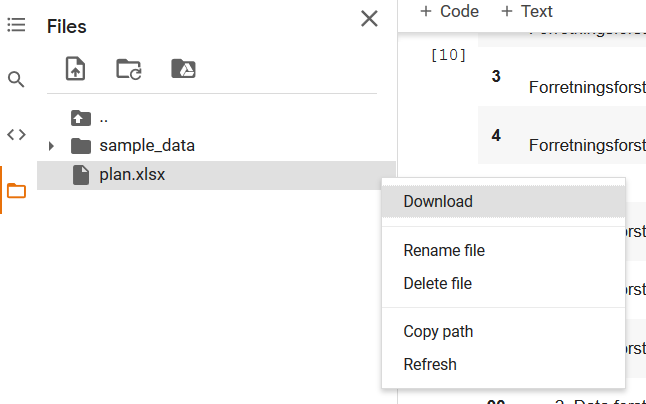

Planen kan også vises, som et interaktivt diagram på følgende måde

In [17]:
#Kildekode av Kostas Mouratidis
# Bruk fremdriften for å finne hvor mye av stolpene som skal fylles
# (dvs. en annen sluttdato)
import altair as alt
import numpy as np
select = alt.selection_interval(empty='all',encodings=['x']) #
select_2 = alt.selection_interval(empty='all',encodings=['x']) #

df["Start_dato"] = pd.to_datetime(df["Start_dato"])
df["Slut_dato"] = pd.to_datetime(df["Slut_dato"])

niveauer_optioner = ['off','3','4']


niveauer = alt.binding_radio(options=niveauer_optioner)


df["Fremskridt_dato"] =  (df["Slut_dato"] - df["Start_dato"]) * df["Fremskridt"] / 100 + df["Start_dato"]

# Sett sammen de to

newdf = np.concatenate([df[[ "Start_dato", "Slut_dato", "Fremskridt","Niveau","Niveau_1","Niveau_2","Niveau_3","Beskrivelse"]].values,  
                        df[["Start_dato", "Fremskridt_dato", "Fremskridt","Niveau","Niveau_1","Niveau_2","Niveau_3","Beskrivelse"]].values])
newdf = pd.DataFrame(newdf, columns=["Start_dato", "Slut_dato", "Fremskridt","Niveau","Niveau_1","Niveau_2","Niveau_3","Beskrivelse"])

newdf['Niveau']=newdf['Niveau'].astype("int")

# Konventere til datetid
newdf["Start_dato"] = pd.to_datetime(newdf["Start_dato"])
newdf["Slut_dato"] = pd.to_datetime(newdf["Slut_dato"])

# Dette er indikatorvariabelen (varighet mot fremgang) der grupperingen foregår
newdf["Fremskridt_"] = np.concatenate([np.ones(len(newdf)//2), np.zeros(len(newdf)//2), ])

# farge for første omgang, farge for andre omgang
range_ = ['#1f77b4', '#5fa0d4',]
range_2 = ['#b41f77', '#d45fa0',]
range_3 = ['#771fb4', '#a05fd4',]
base=alt.Chart(newdf).mark_bar().encode(
    x=alt.X('Start_dato:T', stack=None, title=None),
    x2='Slut_dato:T',
    tooltip=['Niveau_3:N','Beskrivelse:N','Start_dato:T','Slut_dato:T' ],
)

# Det stablede søylediagrammet vil være  "gantt with progress"
chart = base.encode(
    tooltip=['Niveau_1:N','Beskrivelse:N'],
    y=alt.Y('Niveau_1:N', title=None), #sort=list(df.sort_values(["Slut_dato",
                           #                           "Start_dato"])["Aktivitet"])*2),
    color=alt.Color('Fremskridt_', scale=alt.Scale(range=range_), legend=None),
    opacity = alt.condition(select, alt.value(1.0), alt.value(0.2)),
     size="Niveau:Q"
).transform_filter(
    'datum.Niveau==1'
).properties(width=600,height=40)


# Lag egnede etiketter
newdf["tekst"] = newdf["Fremskridt"].astype(str) + " %"


# Og nå legg dem til som tekst i grafen
text = chart.mark_text(align='left', baseline='middle', dx=5, color="darkgrey",  fontWeight="bold").encode(
    y=alt.Y('Niveau_3'), #sort=list(df.sort_values(["Slut_dato",
                           #                           "Start_dato"])["Aktivitet"])*2),
    x=alt.X('Start_dato'),
    text='tekst',
    
)

# Plott grafen
left=alt.layer(chart, text).add_selection(
    select
).add_selection(
    select
)

right=base.encode(
    y=alt.Y('Niveau_2:N', title=None), #sort=list(df.sort_values(["Slut_dato",
                           #                           "Start_dato"])["Aktivitet"])*2),
    tooltip=['Niveau_3:N','Beskrivelse:N','Start_dato:T','Slut_dato:T' ],
    color=alt.Color('Fremskridt_', scale=alt.Scale(range=range_2), legend=None)
).transform_filter(select).properties(width=600,height=80).add_selection(
    select_2
).transform_filter(
    'datum.Niveau==2'
)

right_below=base.mark_bar().encode(
   y=alt.Y('Niveau_3:N', title=None), #sort=list(df.sort_values(["Slut_dato",
                           #                           "Start_dato"])["Aktivitet"])*2),
        #x=alt.X('Start_dato:T', stack=None),
    #x2='Slut_dato:T',
    color=alt.Color('Fremskridt_', scale=alt.Scale(range=range_3), legend=None),

    tooltip=['Niveau_3:N','Beskrivelse:N','Start_dato:T','Slut_dato:T' ],
).transform_filter(select_2).interactive().transform_window(
    row_number='row_number()'
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    'datum.Niveau==niveauer.niveauer'
).properties(width=600,height=300)



crispdm=alt.vconcat(left,right,right_below).add_selection(
    alt.selection_single(fields=['niveauer'], bind=niveauer, name="niveauer")
).configure_axis(
    grid=False
).configure_view(
    strokeOpacity=0
).configure(padding={ 'left' : 50 ,'bottom' : 50  }) #|right_below_2 #.configure(autosize="pad") #

crispdm 

#crispdm.save('forståelse_crispdm.html')

alt.VConcatChart(...)